<a href="https://colab.research.google.com/github/sriksmachi/sriksml/blob/main/reinforcement-learning/reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforce Algorithm

## Introduction

The goal of an agent in Reinforcement learning is to learn optimal behaviour in an environment with an objective to maximize expected rewards.

Reinforcement learning problems can be broadly classified into policy based and value based methods. In value based methods, the agent learns value of an state or state-action pair at every point. The agent then uses those values to maximize the expected rewards. In a way, this is deterministic approach because after the values are learnt, there is no randomness exhibited by the agent to take learn new trajectories.
In contrast, in policy based methods the agent learns the probability distribution of actions that can be taken in a given time step, it then can stochasticaly choose action from the given distribution.

Reinforce (also called monte carlo variation of policy gradient) is a easy and simple to understand RL algorithm that belongs to policy gradient class of algorithms. Policy gradient methods attempt to learn the optimal policy, that is the probability distribution of action that can be taken in every state.
Compared to deterministic algorithms like DQL, stochastic methods like reinforce have an advantage of avoiding abrupt jumps in actions taken for small gradient updates. Since the model is dealing with probabilities of the actions, for smaller gradients the impact on probabilities is also small.

In this notebook you will learn Reinforce algorithm, using a sample built using GYM environment.

Paper Link : [REINFORCE](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


## Intuition

The fundamental idea in reinforce algorithm is - To optimize the expected reward, we can gather trajectories (for both episodic and continuous and continuous tasks). A trajectory is a compbination of state, action taken in that state and reward obtained. For episodic tasks the trajectory continuous until the episode ends. For continuous tasks you may do this for fixed number of times.

The expected reward for each trajectory, is then computed. We can then train a model using the trajectories and expected return such that it reinforces the good actions because good actions lead to higher returns.
(_The loss function for the model is a product of log probability of taking an action and the expected reward._)

Similarly, it tends to push down the probabilities of bad actions. Eventually the model learns only the good actions leading to learning the optimal policy.



## Algorithm

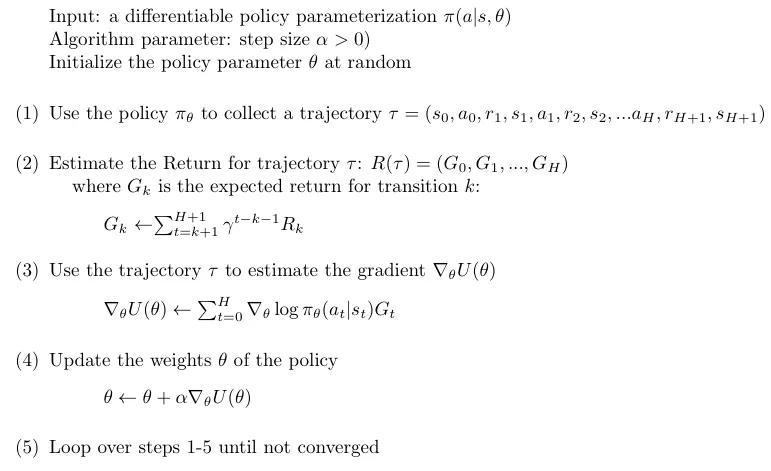

## Training process
The agent goes through following steps
- The model is initialized with initial random weights that acts as an initial policy.
- The agent acts on the environment and collects - next state, reward, action.
- The agents continuous to take action on the environment until it reaches the end state.
- The next state, reward and the action taken are used to calculate the rewards obtained per episode/trajectory.
- The model weights are updated using gradient ascent.
- These steps are repeated until the model converges.

## Code

In [2]:
# hide output
!pip install renderlab > /dev/null 2>&1

In [34]:
import gymnasium as gym
import renderlab as rl

import warnings
warnings.filterwarnings("ignore")

def wrap_env(env):
    env = rl.RenderFrame(env, "./output")
    return env

In [35]:
import tensorflow as tf
import numpy as np
import gym
import tensorflow_probability as tfp
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

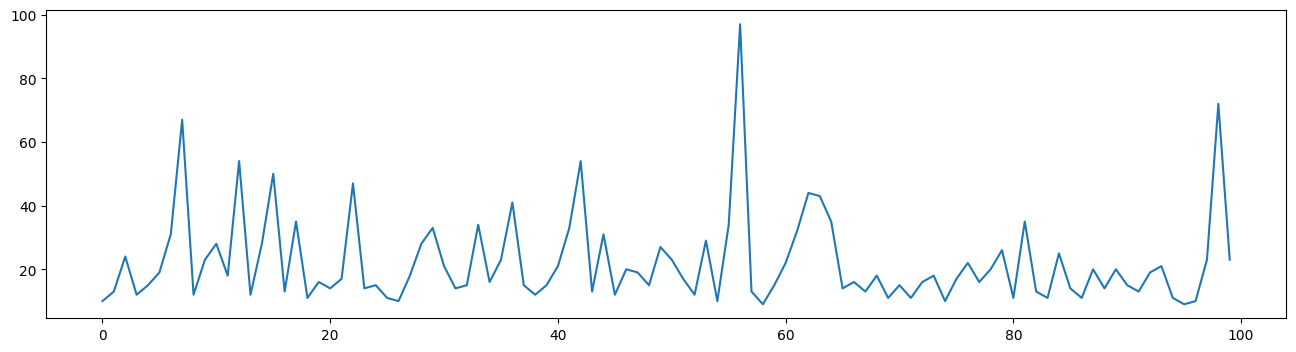

In [38]:
# Lets create a baseine cart pole environment with random agent and run it for 100 episodes
env = gym.make('CartPole-v0')
total_rewards = []
for i in range(100):
  env.reset()
  rewards = []
  terminal = False
  while not terminal:
    action = env.action_space.sample()
    observation, reward, terminal, info = env.step(action)
    rewards.append(reward)
  total_rewards.append(np.sum(rewards))
plt.figure(0, figsize=(16,4))
plt.plot(total_rewards)

Notice the randomness in total rewards, which is expected because there is no model that can guide the agent to take the right steps, Now let us build one.

In [13]:
# initialize
low = env.observation_space.low
high = env.observation_space.high
print(f'Number of action spaces:  {env.action_space.n}')

Number of action spaces:  2


In [14]:
# Policy Model
class model(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.d1 = tf.keras.layers.Dense(64,activation='relu')
    self.d2 = tf.keras.layers.Dense(32,activation='relu')
    self.out = tf.keras.layers.Dense(env.action_space.n,activation='softmax')

  def call(self, input_data):
    x = tf.convert_to_tensor(input_data)
    x = self.d1(x)
    x = self.d2(x)
    x = self.out(x)
    return x

In [15]:
class agent():
  def __init__(self, learning_rate=0.001, gamma=0.99):
    self.model = model()
    self.opt = tf.keras.optimizers.Adam(learning_rate)
    self.gamma = gamma

  def act(self,state):
    # input the current state, model outputs probabilities
    prob = self.model(np.array([state]))
    # convrt to distribution
    dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
    # sample
    action = dist.sample()
    return int(action.numpy()[0])

  def a_loss(self,prob, action, reward):
    dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
    log_prob = dist.log_prob(action)
    # as expalined above the loss is the log probability of action & reward, since it is gradient ascent the loss is marked negative.
    # If reward is 1, the loss is lower than the case when reward is 0
    loss = -log_prob*reward
    return loss

  def train(self, states, rewards, actions):
    sum_reward = 0
    discnt_rewards = []
    rewards.reverse()
    # calculate discounted rewards
    for r in rewards:
      sum_reward = r + self.gamma * sum_reward
      discnt_rewards.append(sum_reward)
    discnt_rewards.reverse()

    for state, reward, action in zip(states, discnt_rewards, actions):
      with tf.GradientTape() as tape:
        # forward pass
        p = self.model(np.array([state]), training=True)
        # compute loss
        loss = self.a_loss(p, action, reward)
      # compute gradients using the loss
      grads = tape.gradient(loss, self.model.trainable_variables)
      # update weights
      self.opt.apply_gradients(zip(grads, self.model.trainable_variables))

  and should_run_async(code)



In [17]:
# params
learning_rate = 0.001
gamma = 0.99

cartpole = agent(learning_rate, gamma)
max_trajectories = 100
rewards_tracked = []
for trajectory in tqdm(range(max_trajectories)):
  done = False
  state = env.reset()
  total_reward = 0
  rewards = []
  states = []
  actions = []
  while not done:
    action = cartpole.act(state)
    next_state, reward, done, info = env.step(action)
    rewards.append(reward)
    states.append(state)
    actions.append(action)
    state = next_state
    total_reward += reward
    if done:
      cartpole.train(states, rewards, actions)
      if trajectory % 10 == 0 and trajectory > 0:
        print('Trajectory {}\tAverage Score: {:.2f}'.format(trajectory, total_reward))
      rewards_tracked.append(total_reward)

 11%|█         | 11/100 [00:05<00:44,  2.02it/s]

Trajectory 10	Average Score: 22.00


 21%|██        | 21/100 [00:10<00:44,  1.78it/s]

Trajectory 20	Average Score: 29.00


 31%|███       | 31/100 [00:18<00:58,  1.19it/s]

Trajectory 30	Average Score: 38.00


 41%|████      | 41/100 [00:37<02:03,  2.09s/it]

Trajectory 40	Average Score: 106.00


 51%|█████     | 51/100 [01:08<02:38,  3.23s/it]

Trajectory 50	Average Score: 108.00


 61%|██████    | 61/100 [01:41<02:22,  3.67s/it]

Trajectory 60	Average Score: 200.00


 71%|███████   | 71/100 [02:03<00:58,  2.03s/it]

Trajectory 70	Average Score: 54.00


 81%|████████  | 81/100 [02:23<00:39,  2.09s/it]

Trajectory 80	Average Score: 105.00


 91%|█████████ | 91/100 [02:58<00:34,  3.80s/it]

Trajectory 90	Average Score: 200.00


100%|██████████| 100/100 [03:43<00:00,  2.24s/it]


## Analysis

In this section we analyse the results of the training by plotting the total rewards against the number of episodes. You may notice that the model learns to hold the cart pole for more time as the training progresses.

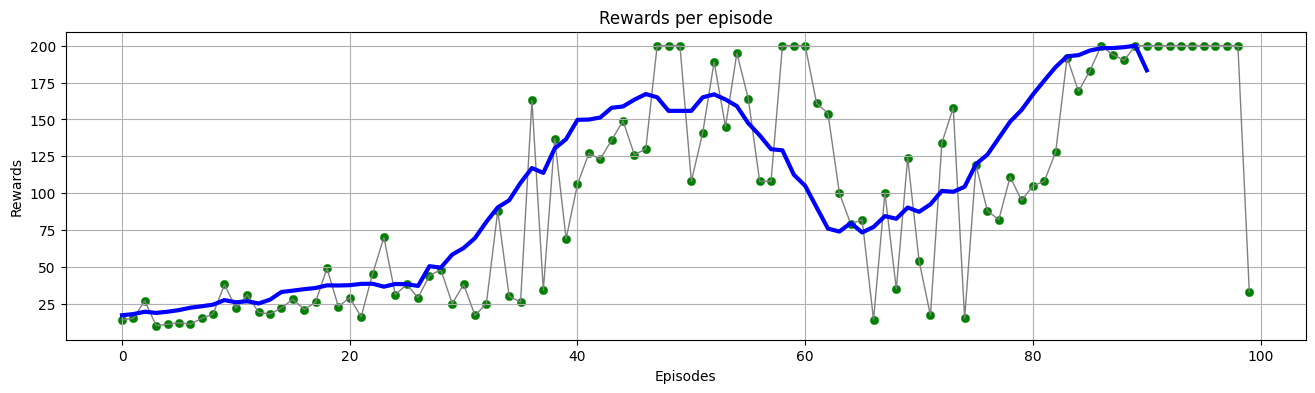

In [30]:
N = 10
x_axis = np.asarray(range(0, max_trajectories))
y_axis = np.asarray(rewards_tracked)
avg_score = np.convolve(rewards_tracked, np.ones(N)/N, mode='valid')
plt.figure(0, figsize=(16,4))
plt.title('Rewards per episode')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.plot(rewards_tracked, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(x_axis, y_axis, color='green' , linewidth=0.3)
plt.grid()
plt.show()

## Evaluate the Model

In [43]:

# Configuration the image rendering in colab

# Taken from
# https://towardsdatascience.com/rendering-openai-gym-envs-on-binder-and-google-colab-536f99391cc7

!apt-get install -y xvfb x11-utils &> /dev/null

!pip install pyvirtualdisplay==0.2.* \
             PyOpenGL==3.1.* \
             PyOpenGL-accelerate==3.1.* &> /dev/null

!pip install gym[box2d]==0.17.* &> /dev/null

# Taken from https://github.com/actions/virtual-environments/issues/214
!sudo apt-get update  &> /dev/null
!sudo apt-get install xvfb --fix-missing &> /dev/null

import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
_ = _display.start()

!echo $DISPLAY # sanity checking: should be set to some value (e.g. 1005)

from IPython import display

:1001


Reward: 142.0


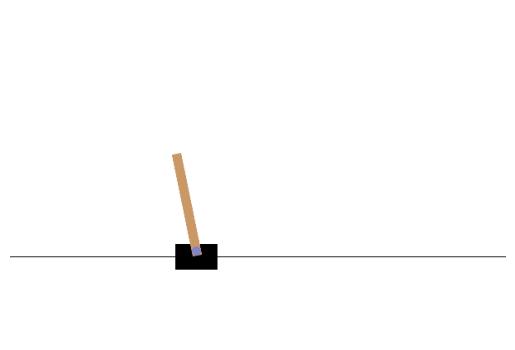

In [44]:
env = gym.make('CartPole-v0')
state = env.reset()
rewards = []
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(2000):
  action = cartpole.act(state)
  img.set_data(env.render(mode='rgb_array'))
  plt.axis('off')
  display.display(plt.gcf())
  display.clear_output(wait=True)
  state, reward, done, _ = env.step(action)
  rewards.append(reward)
  if done:
      print("Reward:", sum([r for r in rewards]))
      break
env.close()
